In [1]:
import torch
from diffusers import AutoencoderKL
from tqdm.notebook import tqdm
import numpy as np
from transformer.microdit import LitMicroDiT, MicroDiT
import matplotlib.pyplot as plt
from transformer.utils import strings_to_tensor
from datasets import load_dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
train_ds = load_dataset("../../datasets/commoncatalog_cc_by_moondream_latents", split="train")

In [13]:
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path="madebyollin/sdxl-vae-fp16-fix", cache_dir="../../models/vae").to(device)

In [14]:
bs = 32
input_dim = 4  # 4 channels in latent space
patch_size = (2, 2)
# embed_dim = 1152
# num_layers = 28
# num_heads = 16
embed_dim = 384
num_layers = 12
num_heads = 6
mlp_dim = embed_dim * 4
caption_embed_dim = 1152  # SigLip embeds to 1152 dims
# pos_embed_dim = 60
pos_embed_dim = None
# timestep_caption_embed_dim = 60
timestep_caption_embed_dim = None
num_experts = 8
active_experts = 2
patch_mixer_layers = 1
dropout = 0.1
embed_cat = False

epochs = 5
mask_ratio = 0.75

In [15]:
model = MicroDiT(input_dim, patch_size, embed_dim, num_layers, 
                num_heads, mlp_dim, caption_embed_dim, timestep_caption_embed_dim,
                pos_embed_dim, num_experts, active_experts,
                dropout, patch_mixer_layers, embed_cat)
model = LitMicroDiT(model)
model.load_state_dict(torch.load("models/diffusion/epoch=4-step=155.ckpt")["state_dict"])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27572\922940148.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/diffusion/epoch=4-ste

<All keys matched successfully>

In [16]:
model = model.to(device)

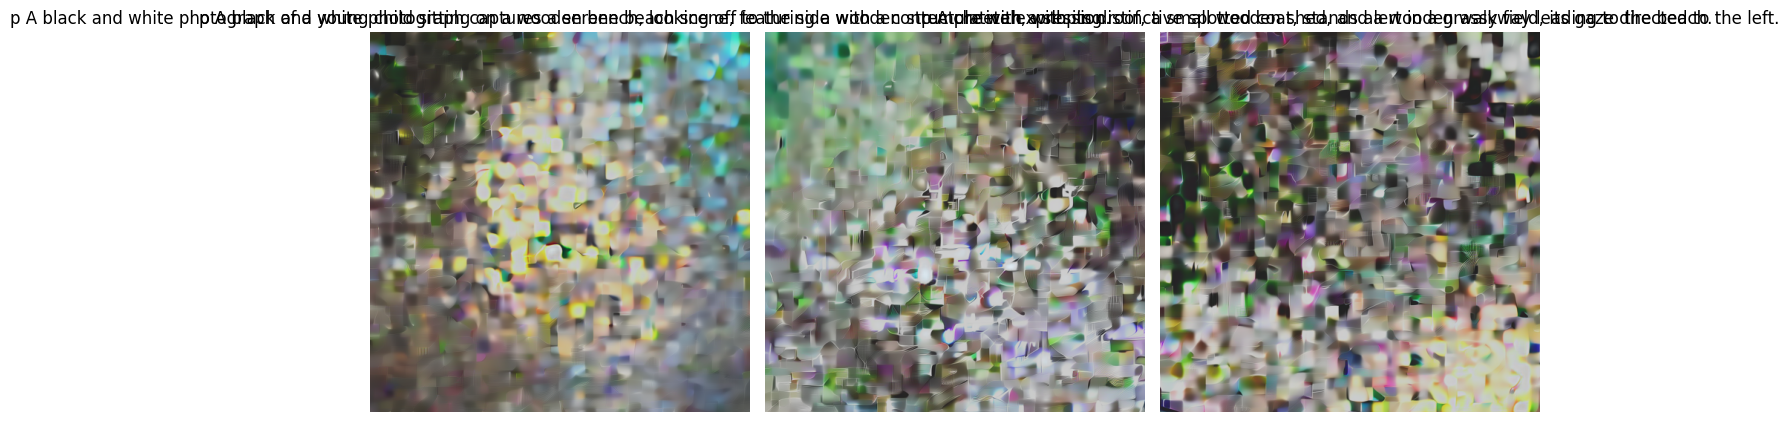

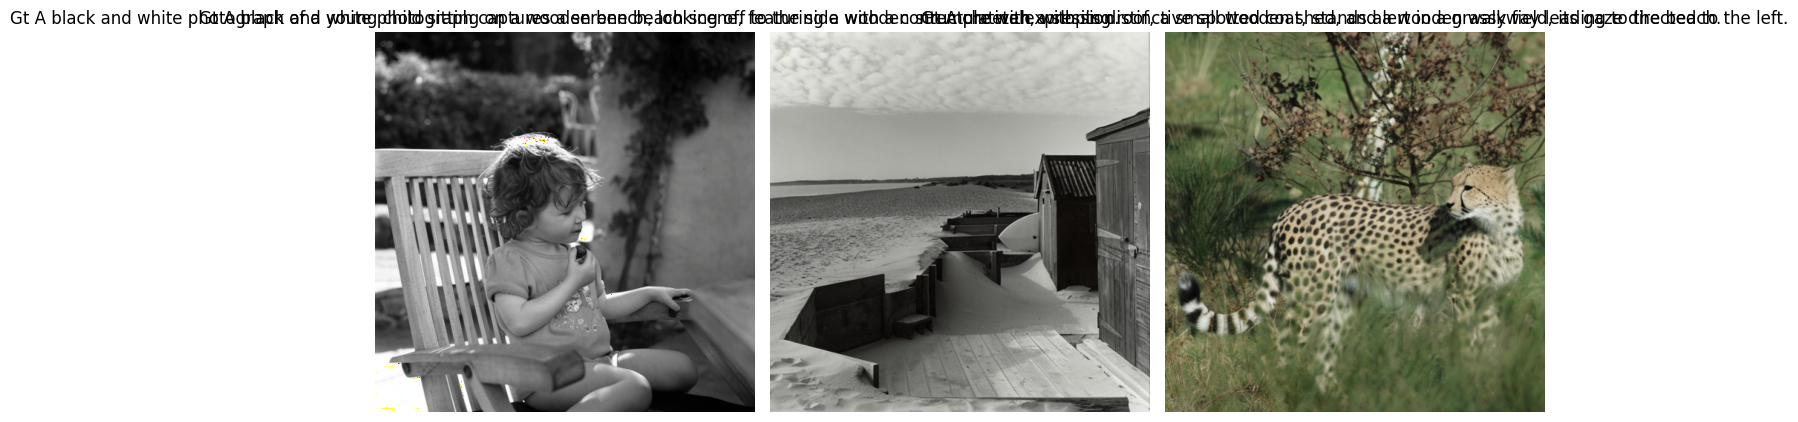

In [25]:
noise = torch.randn(3, VAE_CHANNELS, 64, 64).to(device)

latents = torch.tensor(train_ds[:3]["latent"]).to(device).reshape(3, VAE_CHANNELS, 64, 64)
caption_embeddings = torch.tensor(train_ds[:3]["embedding"]).to(device)
image_captions = train_ds[:3]["caption"]

with torch.inference_mode():
    pred = model.sample(noise, caption_embeddings, sample_steps=10)

    pred = vae.decode(pred).sample
    # Change range of pred from x to y to -1 to 1
    min_val = pred.min()
    max_val = pred.max()

    pred = (pred - min_val) / (max_val - min_val)
    pred = 2 * pred - 1

ground_truth = vae.decode(latents.to(device).to(torch.float32)).sample

with torch.inference_mode():
    pred_cpu = pred.cpu()
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    ground_truth_cpu = ground_truth.cpu()
    ground_truth_np = ground_truth_cpu.permute(0, 2, 3, 1).numpy()
    ground_truth_np = (ground_truth_np + 1) / 2
    ground_truth_np = (ground_truth_np * 255).astype(np.uint8)  # Convert to uint8
    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(1, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            ax.set_title(f'p {image_captions[i]}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Create figure for ground truth
    fig_gt, axes_gt = plt.subplots(1, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot ground truth
    for i, ax in enumerate(axes_gt.flatten()):
        if i < ground_truth_np.shape[0]:
            ax.imshow(ground_truth_np[i])
            ax.set_title(f'Gt {image_captions[i]}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()